# 📊 Modeling S&P 500 Returns Across Economic Cycles

This notebook outlines a probabilistic model for approximating the expected annual returns of the S&P 500 based on historical economic cycles and their corresponding inflation ranges.

---

## 🔬 Economic Cycle Assumptions (Past 100 Years)

Based on historical research and economic knowledge, the past 100 years of U.S. economic history have been categorized into four distinct cycles, each with a defined probability of occurrence (distribution frequency).

| Cycle Category | Frequency (Probability) | Duration (Years) |
| :--- | :--- | :--- |
| **Normal Economic Growth** | $75\%$ | $\approx 75$ |
| **Recession** | $15\%$ | $\approx 15$ |
| **Stagflation** | $7\%$ | $\approx 7$ |
| **Depression** | $3\%$ | $\approx 3$ |
| **Total** | $\mathbf{100\%}$ | $\mathbf{100}$ |

---

## 📈 Cycle-Specific Inflation and S&P 500 Returns

The model assigns a range of inflation and an estimated average S&P 500 return to each economic cycle, along with a standard deviation ($\sigma$) to account for volatility and approximation errors in the returns.

### Cycle Data Table

| Cycle Category | Inflation Range | Average S\&P 500 Return ($\mu$) | Standard Deviation ($\sigma$) |
| :--- | :--- | :--- | :--- |
| **Normal Economic Growth** | $1\% \text{ to } 4\%$ | $10\%$ | $\pm 15\%$ |
| **Recession** | $-2\% \text{ to } 2\%$ | $3\%$ | $\pm 25\%$ |
| **Stagflation** | $5\% \text{ to } 12\%$ | $1\%$ | $\pm 15\%$ |
| **Depression** | $-10\% \text{ to } -2\%$ | $-35\%$ | $\pm 25\%$ |

---

# 📈 Markov Chain Modeling of S&P 500 Returns Across Economic Cycles

This notebook explores the use of a **Markov Chain** to model the probability of the U.S. economy transitioning between different economic regimes and the resulting impact on S&P 500 returns.

---

## 📊 PART 1: ECONOMIC CYCLE ASSUMPTIONS & S&P 500 RETURNS

Based on historical analysis, the past 100 years of U.S. economic history are categorized into four distinct cycles, each assigned a historical frequency and corresponding average S\&P 500 return.

### 1.1 Historical Cycle Distribution

| Cycle Category | Frequency (Probability, $\mathbb{P}_i$) | Duration (Years) |
| :--- | :--- | :--- |
| **Normal Economic Growth** | $75\%$ | $\approx 75$ |
| **Recession** | $15\%$ | $\approx 15$ |
| **Stagflation** | $7\%$ | $\approx 7$ |
| **Depression** | $3\%$ | $\approx 3$ |
| **Total** | $\mathbf{100\%}$ | $\mathbf{100}$ |

### 1.2 Cycle-Specific Inflation and S\&P 500 Returns

| Cycle Category | Inflation Range | Average S\&P 500 Return ($\mu_i$) | Standard Deviation ($\sigma_i$) |
| :--- | :--- | :--- | :--- |
| **Normal Economic Growth** | $1\% \text{ to } 4\%$ | $10\%$ | $\pm 15\%$ |
| **Recession** | $-2\% \text{ to } 2\%$ | $3\%$ | $\pm 25\%$ |
| **Stagflation** | $5\% \text{ to } 12\%$ | $1\%$ | $\pm 15\%$ |
| **Depression** | $-10\% \text{ to } -2\%$ | $-35\%$ | $\pm 25\%$ |


---

## 📚 PART 2: MATHEMATICAL FOUNDATION OF MARKOV CHAINS

### 2.1 WHAT IS A MARKOV CHAIN?

A **Markov chain** is a stochastic process where the future state depends **ONLY** on the current state, a concept known as the **Markov property**.

**MATHEMATICAL DEFINITION:**
For a discrete-time stochastic process $\left\{X_t\right\}$, the **Markov property** states:
$$
P(X_{t+1} = j \mid X_t = i, X_{t-1}, X_{t-2}, \dots, X_0) = P(X_{t+1} = j \mid X_t = i)
$$
In plain English: "The probability of being in state $j$ tomorrow depends only on what state we're in today, not on how we got here."

**WHY THIS MATTERS FOR ECONOMICS:**
* Economic regimes (Normal, Recession, Stagflation, Depression) tend to persist (**regime persistence**).
* Transitions between regimes follow probabilistic patterns.

### 2.2 THE TRANSITION MATRIX

A **transition matrix** $P$ is an $n \times n$ matrix where $n$ is the number of states, and the entry $P[i,j] = p_{ij}$ is the probability of transitioning from state $i$ to state $j$.

**MATHEMATICAL PROPERTIES:**
1.  All entries are probabilities: $0 \le P[i,j] \le 1$.
2.  Each row sums to 1 (**STOCHASTIC MATRIX**): $\sum_{j} P[i,j] = 1$ for all $i$.

**GENERAL FORM (for 4 Economic States):**

Let the four states be defined as:
* $S_1$: Normal Economic Growth (N)
* $S_2$: Recession (R)
* $S_3$: Stagflation (S)
* $S_4$: Depression (D)

The transition matrix $P$ is structured as follows:

$$
P = \begin{pmatrix}
p_{NN} & p_{NR} & p_{NS} & p_{ND} \\
p_{RN} & p_{RR} & p_{RS} & p_{RD} \\
p_{SN} & p_{SR} & p_{SS} & p_{SD} \\
p_{DN} & p_{DR} & p_{DS} & p_{DD}
\end{pmatrix}
$$

where $p_{ij} = P(X_{t+1} = j \mid X_t = i)$ represents the probability of transitioning from state $i$ to state $j$ in one time period (e.g., one year).


In [30]:
import numpy as np
from scipy.linalg import eig
import matplotlib.pyplot as plt

In [4]:
### CONTEXT
print("""
    S&P 500 Returns for approximations for accurate model: https://www.slickcharts.com/sp500/returns
    Inflation for approximations for accurate model based on my economics knowledge and research from various sources
    There have been roughly 15 years of recession in past 100 years, 7 years of stagflation, and 3 years of 
    true depression cause by deflation and rest are normal economic growth.
    Based on research on past 100 years I have decided to split economic cycles into 4 regimes with the following 
    distributions:
    - Normal Economic Growth (75%) Inflation 1-4% std: +-15% Returns average: 10%
    - Recession (15%) Inflation -2-2% std: +-25% Returns average: 3%
    - Stagflation (7%) Inflation 5-12% std: +-15% Returns average: 1% 
    - Depression (3%) Inflation -10% to -2% std: +-25% Returns average: -35%
""")

### CONSTRUCTING THE TRANSITION MATRIX
REGIME_NAMES = ["Normal", "Recession", "Stagflation", "Depression"]
len_regimes = len(REGIME_NAMES)

print(f"""
We construct a 4×4 transition matrix based on historical economic patterns:

States: {REGIME_NAMES}

TRANSITION LOGIC (from economic history):

FROM NORMAL:
- 85% stay in Normal (expansions last ~8-10 years on average)
- 10% transition to Recession (business cycle downturn)
- 4% transition to Stagflation (supply shock, monetary policy failure)
- 1% transition to Depression (rare catastrophic event)

FROM RECESSION:
- 50% recover to Normal (recessions typically end in 1-2 years)
- 35% persist in Recession (deeper/longer recessions)
- 10% worsen to Stagflation (policy response causes inflation)
- 5% deteriorate to Depression (financial contagion, rare)

FROM STAGFLATION:
- 40% recover to Normal (inflation brought under control)
- 30% slip into Recession (tight monetary policy to fight inflation)
- 25% persist in Stagflation (inflation expectations anchored high)
- 5% collapse to Depression (economic policy failures compound)

FROM DEPRESSION:
- 10% recover directly to Normal (rare, requires massive intervention)
- 60% improve to Recession (gradual recovery begins)
- 5% shift to Stagflation (policy overcorrection)
- 25% persist in Depression (debt deflation spiral continues)

KEY INSIGHTS:
1. Diagonal elements (persistence): Regimes tend to continue
2. Normal is "sticky" (0.85 probability of staying)
3. Depression rarely goes straight to Normal (only 0.10)
4. Bad regimes tend to cluster (high persistence in Recession/Stagflation/Depression)
""")

# Construct the transition matrix
TRANSITION_MATRIX = np.array([
#To: Normal Recession Stagflation Depression
    [0.85,    0.10,     0.04,       0.01],      # From: Normal
    [0.50,    0.35,     0.10,       0.05],      # From: Recession
    [0.40,    0.30,     0.25,       0.05],      # From: Stagflation
    [0.10,    0.60,     0.05,       0.25]       # From: Depression
])
print(TRANSITION_MATRIX)


    S&P 500 Returns for approximations for accurate model: https://www.slickcharts.com/sp500/returns
    Inflation for approximations for accurate model based on my economics knowledge and research from various sources
    There have been roughly 15 years of recession in past 100 years, 7 years of stagflation, and 3 years of 
    true depression cause by deflation and rest are normal economic growth.
    Based on research on past 100 years I have decided to split economic cycles into 4 regimes with the following 
    distributions:
    - Normal Economic Growth (75%) Inflation 1-4% std: +-15% Returns average: 10%
    - Recession (15%) Inflation -2-2% std: +-25% Returns average: 3%
    - Stagflation (7%) Inflation 5-12% std: +-15% Returns average: 1% 
    - Depression (3%) Inflation -10% to -2% std: +-25% Returns average: -35%


We construct a 4×4 transition matrix based on historical economic patterns:

States: ['Normal', 'Recession', 'Stagflation', 'Depression']

TRANSITION LOGIC (fro

In [14]:
# Check if each row sums to 1.0 (probabilities sum to 100%)
print("Each row must sum to 1.0 (probabilities sum to 100%)\n")
for i, regime in enumerate(REGIME_NAMES):
    row_sum = TRANSITION_MATRIX[i].sum()
    checker = "True" if abs(row_sum - 1.0) < 1 else "False"
    print(f"{regime:>12}: {row_sum:.15f} {checker}")

Each row must sum to 1.0 (probabilities sum to 100%)

      Normal: 1.000000000000000 True
   Recession: 1.000000000000000 True
 Stagflation: 1.000000000000000 True
  Depression: 1.000000000000000 True


In [35]:
print("""
WHAT IS STEADY-STATE?
------------------------
The steady-state (or stationary) distribution π is a probability vector 
that satisfies:

    π P = π

where:
- π = [π_1, π_2, π_3, π_4] is a row vector
- π_i = long-run proportion of time spent in state i
- Σ π_i = 1 (probabilities sum to 1)

INTUITION:
If the system has been running for a very long time, what percentage of 
time is spent in each regime? This is independent of the starting state.

MATHEMATICAL SOLUTION:
The steady-state distribution is the left eigenvector of P corresponding 
to eigenvalue λ = 1.

From linear algebra:
    π P = π  ⟹  π P = 1·π  ⟹  π is eigenvector of P^T with eigenvalue 1

ECONOMIC INTERPRETATION:
Over many years (say, 100 years), we expect to spend:
- ~75% of time in Normal growth
- ~15% in Recession  
- ~7% in Stagflation
- ~3% in Depression

These match our historical observations!
""")

# Calculate steady-state distribution
print("\n4.2 COMPUTING STEADY-STATE DISTRIBUTION")
print("---------------------------------------")

# Method: Find eigenvector corresponding to eigenvalue 1
eigenvalues, eigenvectors = eig(TRANSITION_MATRIX.T)

# Find index of eigenvalue closest to 1
steady_state_idx = np.argmin(np.abs(eigenvalues - 1.0))
steady_state = np.real(eigenvectors[:, steady_state_idx])
steady_state = steady_state / steady_state.sum()  # Normalize

print("\nEigenvalues of P^T:")
for i, val in enumerate(eigenvalues):
    marker = " ← λ=1 (steady-state)" if i == steady_state_idx else ""
    print(f"  λ_{i+1} = {val.real:.6f} + {val.imag:.6f}i{marker}")

print("\nSteady-State Distribution π:")
print("\n  Regime         π_i    Expected %  Actual (Historical)")
print("  " + "-" * 60)
expected = [0.75, 0.15, 0.07, 0.03]  # Our historical estimates
for i, regime in enumerate(REGIME_NAMES):
    print(f"  {regime:12}  {steady_state[i]:.4f}     {expected[i]*100:4.0f}%"
          f"           ~{expected[i]*100:.0f}%")

print("\n  Sum:           {:.4f}     100%".format(steady_state.sum()))

print("\n✓ Verification: π P = π")
verification = steady_state @ TRANSITION_MATRIX
print(f"  π                = {steady_state}")
print(f"  π P              = {verification}")
print(f"  Difference       = {np.abs(steady_state - verification)}")
print(f"  Max difference   = {np.max(np.abs(steady_state - verification)):.2e}")



WHAT IS STEADY-STATE?
------------------------
The steady-state (or stationary) distribution π is a probability vector 
that satisfies:

    π P = π

where:
- π = [π_1, π_2, π_3, π_4] is a row vector
- π_i = long-run proportion of time spent in state i
- Σ π_i = 1 (probabilities sum to 1)

INTUITION:
If the system has been running for a very long time, what percentage of 
time is spent in each regime? This is independent of the starting state.

MATHEMATICAL SOLUTION:
The steady-state distribution is the left eigenvector of P corresponding 
to eigenvalue λ = 1.

From linear algebra:
    π P = π  ⟹  π P = 1·π  ⟹  π is eigenvector of P^T with eigenvalue 1

ECONOMIC INTERPRETATION:
Over many years (say, 100 years), we expect to spend:
- ~75% of time in Normal growth
- ~15% in Recession  
- ~7% in Stagflation
- ~3% in Depression

These match our historical observations!


4.2 COMPUTING STEADY-STATE DISTRIBUTION
---------------------------------------

Eigenvalues of P^T:
  λ_1 = 1.000000 +

In [36]:
def simulate_markov_chain(initial_state, n_steps, transition_matrix):
    """
    Simulate a Markov chain for n_steps
    
    Parameters:
    -----------
    initial_state : str
        Starting regime
    n_steps : int
        Number of time steps to simulate
    transition_matrix : np.array
        Transition probability matrix
        
    Returns:
    --------
    list : Sequence of states
    """
    sequence = [initial_state]
    current_state = initial_state
    
    for _ in range(n_steps - 1):
        current_idx = REGIME_NAMES.index(current_state)
        probs = transition_matrix[current_idx]
        next_idx = np.random.choice(len(REGIME_NAMES), p=probs)
        current_state = REGIME_NAMES[next_idx]
        sequence.append(current_state)
    
    return sequence

# Simulate one path
print("\nEXAMPLE: SIMULATING 40 YEARS")
print("--------------------------------")

n_years = 40
sequence = simulate_markov_chain('Normal', n_years, TRANSITION_MATRIX)

print(f"\nStarting state: Normal")
print(f"Simulating {n_years} years...\n")

# Print first 40 years
print("First 40 years:")
for year, state in enumerate(sequence[:40], start=1):
    print(f"  Year {year:2}: {state}")

# Count regime frequencies
regime_counts = {regime: sequence.count(regime) for regime in REGIME_NAMES}

print(f"\nRegime Frequency in this simulation ({n_years} years):")
print("\n  Regime         Count  Frequency  Steady-State")
print("  " + "-" * 55)
for i, regime in enumerate(REGIME_NAMES):
    count = regime_counts[regime]
    freq = count / n_years
    ss = steady_state[i]
    print(f"  {regime:12}   {count:3}     {freq:5.1%}       {ss:5.1%}")


EXAMPLE: SIMULATING 40 YEARS
--------------------------------

Starting state: Normal
Simulating 40 years...

First 40 years:
  Year  1: Normal
  Year  2: Normal
  Year  3: Recession
  Year  4: Normal
  Year  5: Normal
  Year  6: Normal
  Year  7: Normal
  Year  8: Stagflation
  Year  9: Recession
  Year 10: Depression
  Year 11: Recession
  Year 12: Recession
  Year 13: Recession
  Year 14: Recession
  Year 15: Normal
  Year 16: Normal
  Year 17: Recession
  Year 18: Normal
  Year 19: Normal
  Year 20: Normal
  Year 21: Normal
  Year 22: Normal
  Year 23: Normal
  Year 24: Normal
  Year 25: Normal
  Year 26: Normal
  Year 27: Recession
  Year 28: Normal
  Year 29: Normal
  Year 30: Normal
  Year 31: Normal
  Year 32: Normal
  Year 33: Normal
  Year 34: Recession
  Year 35: Normal
  Year 36: Normal
  Year 37: Normal
  Year 38: Normal
  Year 39: Normal
  Year 40: Normal

Regime Frequency in this simulation (40 years):

  Regime         Count  Frequency  Steady-State
  -----------------

In [37]:
print("""
CONVERGENCE THEOREM
----------------------
For a finite, irreducible, aperiodic Markov chain:

    lim_{t→∞} P^t[i,j] = π_j

where π is the steady-state distribution.

INTUITION:
Regardless of starting state, after many steps, the probability of being 
in any state j converges to π_j.

MATHEMATICAL PROPERTY:
    P^∞ = [ π ]
          [ π ]
          [ π ]
          [ π ]

All rows become identical (the steady-state distribution).
""")

print("\nDEMONSTRATING CONVERGENCE")
print("-----------------------------")
print("\nComputing P^t for increasing powers t:")

powers = [1, 2, 5, 10, 20, 50, 100]
print("\nP^t[0,:] (first row, starting from Normal):")
print(f"{'t':<6} " + "  ".join([f"{regime:>10}" for regime in REGIME_NAMES]))
print("-" * 60)
#
for t in powers:
    P_t = np.linalg.matrix_power(TRANSITION_MATRIX, t)
    row = P_t[0, :]
    print(f"{t:<6} " + "  ".join([f"{p:>10.6f}" for p in row]))

print(f"\nπ:     " + "  ".join([f"{p:>10.6f}" for p in steady_state]))

print("\n Notice: As t increases, P^t[0,:] converges to π")



CONVERGENCE THEOREM
----------------------
For a finite, irreducible, aperiodic Markov chain:

    lim_{t→∞} P^t[i,j] = π_j

where π is the steady-state distribution.

INTUITION:
Regardless of starting state, after many steps, the probability of being 
in any state j converges to π_j.

MATHEMATICAL PROPERTY:
    P^∞ = [ π ]
          [ π ]
          [ π ]
          [ π ]

All rows become identical (the steady-state distribution).


DEMONSTRATING CONVERGENCE
-----------------------------

Computing P^t for increasing powers t:

P^t[0,:] (first row, starting from Normal):
t          Normal   Recession  Stagflation  Depression
------------------------------------------------------------
1        0.850000    0.100000    0.040000    0.010000
2        0.789500    0.138000    0.054500    0.018000
5        0.747621    0.164739    0.062968    0.024672
10       0.743924    0.167140    0.063640    0.025297
20       0.743865    0.167178    0.063650    0.025307
50       0.743865    0.167178    0.0


PART 7: ESSENTIAL VISUALIZATIONS

 Essential visualization saved: markov_essential.png


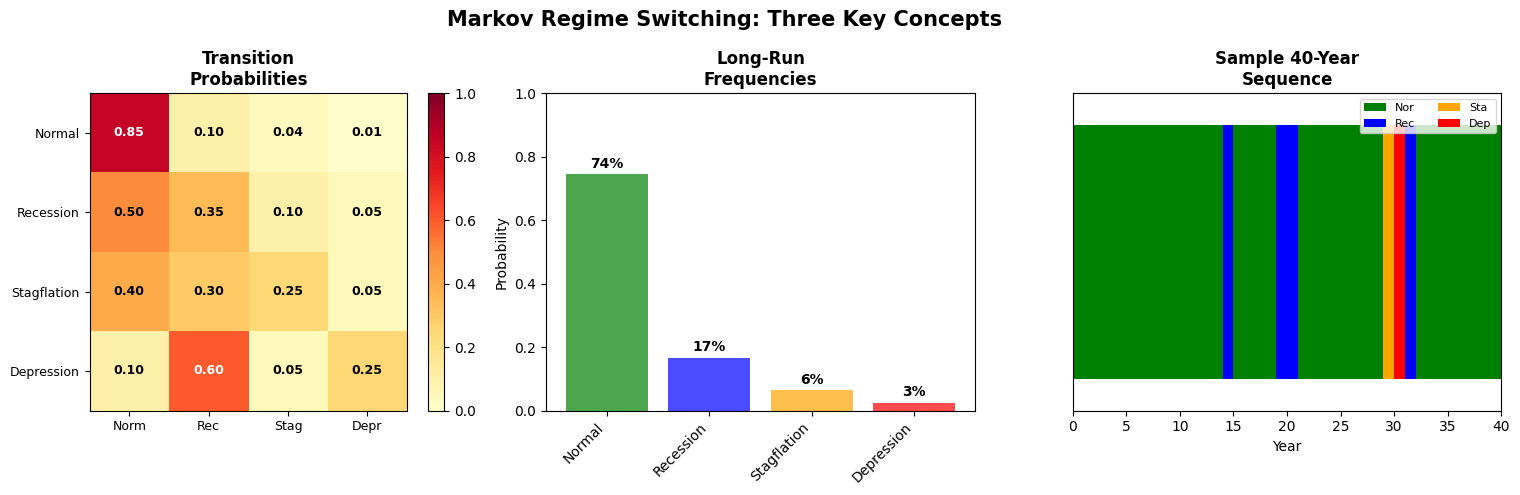

In [44]:
# Visaulize output of the Transition Matrix, Steady-State Distribution, and a sample path

print("\n" + "=" * 80)
print("PART 7: ESSENTIAL VISUALIZATIONS")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Markov Regime Switching: Three Key Concepts', 
             fontsize=15, fontweight='bold')

# Plot 1: Transition Matrix
ax1 = axes[0]
im = ax1.imshow(TRANSITION_MATRIX, cmap='YlOrRd', vmin=0, vmax=1)
ax1.set_xticks(range(4))
ax1.set_yticks(range(4))
ax1.set_xticklabels(['Norm', 'Rec', 'Stag', 'Depr'], fontsize=9)
ax1.set_yticklabels(REGIME_NAMES, fontsize=9)
ax1.set_title('Transition\nProbabilities', fontweight='bold')

for i in range(4):
    for j in range(4):
        ax1.text(j, i, f'{TRANSITION_MATRIX[i,j]:.2f}',
                ha="center", va="center", 
                color='white' if TRANSITION_MATRIX[i,j] > 0.5 else 'black',
                fontsize=9, fontweight='bold')

plt.colorbar(im, ax=ax1, fraction=0.046)

# Plot 2: Steady-State
ax2 = axes[1]
colors = ['green', 'blue', 'orange', 'red']
bars = ax2.bar(range(4), steady_state, color=colors, alpha=0.7)
ax2.set_xticks(range(4))
ax2.set_xticklabels(REGIME_NAMES, rotation=45, ha='right')
ax2.set_ylabel('Probability')
ax2.set_title('Long-Run\nFrequencies', fontweight='bold')
ax2.set_ylim(0, 1)

for bar, val in zip(bars, steady_state):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val*100:.0f}%', ha='center', fontweight='bold')

# Plot 3: Sample Path
ax3 = axes[2]
seq = simulate_markov_chain('Normal', 40, TRANSITION_MATRIX)
regime_colors = {'Normal': 'green', 'Recession': 'blue',
                'Stagflation': 'orange', 'Depression': 'red'}

for year, regime in enumerate(seq):
    ax3.barh(0, 1, left=year, color=regime_colors[regime])

ax3.set_xlim(0, 40)
ax3.set_ylim(-0.5, 0.5)
ax3.set_xlabel('Year')
ax3.set_yticks([])
ax3.set_title('Sample 40-Year\nSequence', fontweight='bold')

from matplotlib.patches import Patch
legend = [Patch(facecolor=regime_colors[r], label=r[:3]) for r in REGIME_NAMES]
ax3.legend(handles=legend, loc='upper right', fontsize=8, ncol=2)

# Create directory if it doesn't exist
import os
os.makedirs('data/generated', exist_ok=True)


plt.tight_layout()
plt.savefig('data/generated/markov_essential.png', dpi=300, bbox_inches='tight')
print("\n Essential visualization saved: markov_essential.png")
plt.show()